In [27]:
import math
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.style.use('fivethirtyeight')

**Exact solution using Black-Scholes formula**

The exact price of the european call option $C(S,t)$, given the maturity $T$ and strike price $K$ is given by the following formula:
$$C(S,t) = SN(d_1) - e^{-r(T- t)}K N(d_2) $$
where:
$$d_1 = \frac{ln(S/K) + (r*\frac{\sigma^2}{2})(\Delta T)}{\sigma \sqrt{ΔT}}$$
$$d_2 = d_1 - \sigma \sqrt{\Delta T}$$
and $\Delta T = T - t$ is difference between current time $t$ and maturity $T$.

In [2]:
  def BS(S,K,deltaT):
    d2=(math.log(S/K)+(r-pow(sigma,2)/2)*(deltaT))/(sigma*math.sqrt(deltaT))
    d1=d2+sigma*math.sqrt(deltaT)
    C=S*norm.cdf(d1)-K*norm.cdf(d2)*math.exp(-r*(deltaT))
    return C

We will compute the price of an option with the following charactiristics.

In [3]:
r=0.02 # annualized risk-free interest rate
sigma=0.2 #  is the standard deviation/ volatility of the stock's returns
deltaT=0.5 # time to maturity
s0=102# stock's price
K=100# strike price
k = 1000000


The price of an option with given characteristics is the following:

In [4]:
BS(s0,K,deltaT)

7.288151182771621

When $\Delta T \approx 0$, i.e. close to maturity, the call option payoff has its standard form.

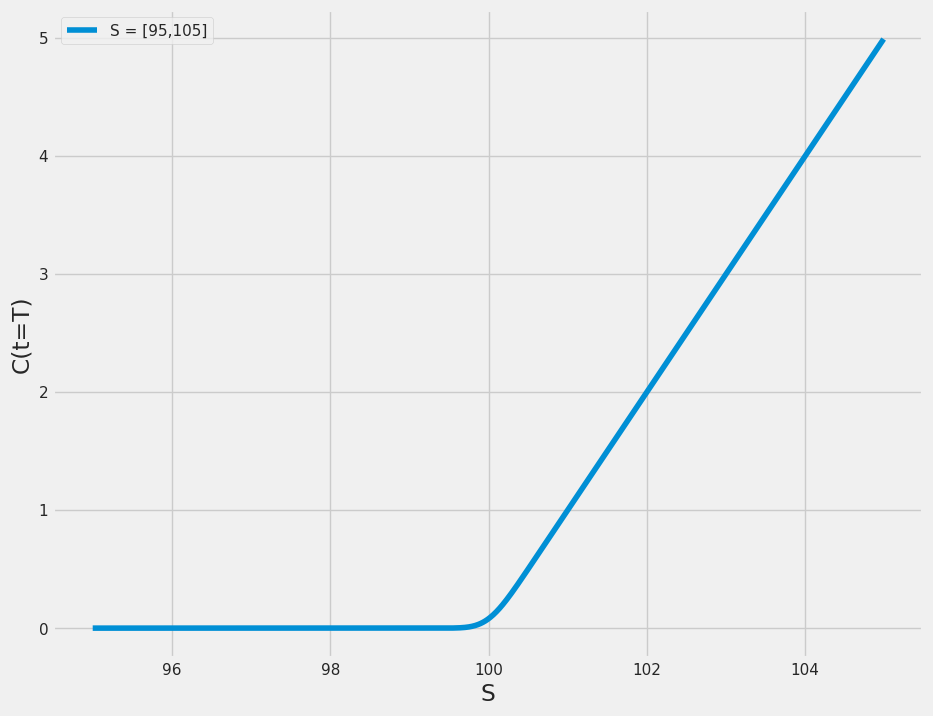

In [5]:
s = np.arange(95, 105, 0.01)
vfunc = np.vectorize(BS, excluded=['K',"deltaT"])
R = vfunc(s, deltaT=0.0001,K = 100)
plt.figure(figsize = (10,8))
sns.lineplot(y = R, x = s, label = 'S = [95,105]')

plt.xlabel('S')
plt.ylabel('C(t=T)')

plt.legend()
plt.show()

**Monte Carlo Method**

In this section we will compute the price of an european call option using using naive Monte Carlo simulations. The standard Monte Carlo estimator using
n scenarios is the following:
$$\hat{C}_{0,n}=\frac{e^{-r\Delta T} }{n}\sum_{i=1}^{n}\phi(s_{i})$$
$$\phi (x) = (x- K)^+$$
where K is a strike price and $s_{i,0}=S_{0}$ is initial price of the stock, $s_{i,T}=s_{i,t}e^{(r-\frac{\sigma^{2}}{2})+\sigma\sqrt{\Delta T}z_{i}}$ is value of the stock at maturity time on $i^{th}$ scenario and $z_{i}$ is samples of i.i.d. realization of standard Normal random variable.


In [6]:
def Crude_Monte_Carlo(k, r, sigma, deltaT, K, s0):# the price of the product at the maturnity simulation
    z = np.random.normal(0, 1, [1, k])
    S= s0*np.exp((r-(sigma**2)/2)*deltaT+sigma*math.sqrt(deltaT)*z) - K
    R = math.exp(-r*deltaT)*np.sum(S[S>0])/k
    return R

In [7]:
Crude_Monte_Carlo(1000000, r, sigma, deltaT, K,s0)

7.276346390144392

Let's compute an standart error of the option price that is computed using Monte Carlo simulation. $$SE(\hat{C}_{0,n}) = \frac{SD(\hat{C}_{0,n})}{\sqrt{n}}$$ where n in a number of simulations and $SD(\hat{C}_{0,n})$ is standatd deviation of $\hat{C}_{0,n}$.

In [8]:
def STERR_Crude_MC(k, r, sigma, deltaT, K, s0):# the price of the product at the maturnity simulation
    z = np.random.normal(0, 1, [1, k])
    S= s0*np.exp((r-(sigma**2)/2)*deltaT+sigma*math.sqrt(deltaT)*z) - K
    R = math.exp(-r*deltaT)*S[S>0]
    R = np.std(R)/np.sqrt(k)
    return R

For number of simulations $t$ standard error is the following:

In [9]:
t = 1000000
STERR_Crude_MC(t, r, sigma, deltaT, K, s0)

0.010404632057610604

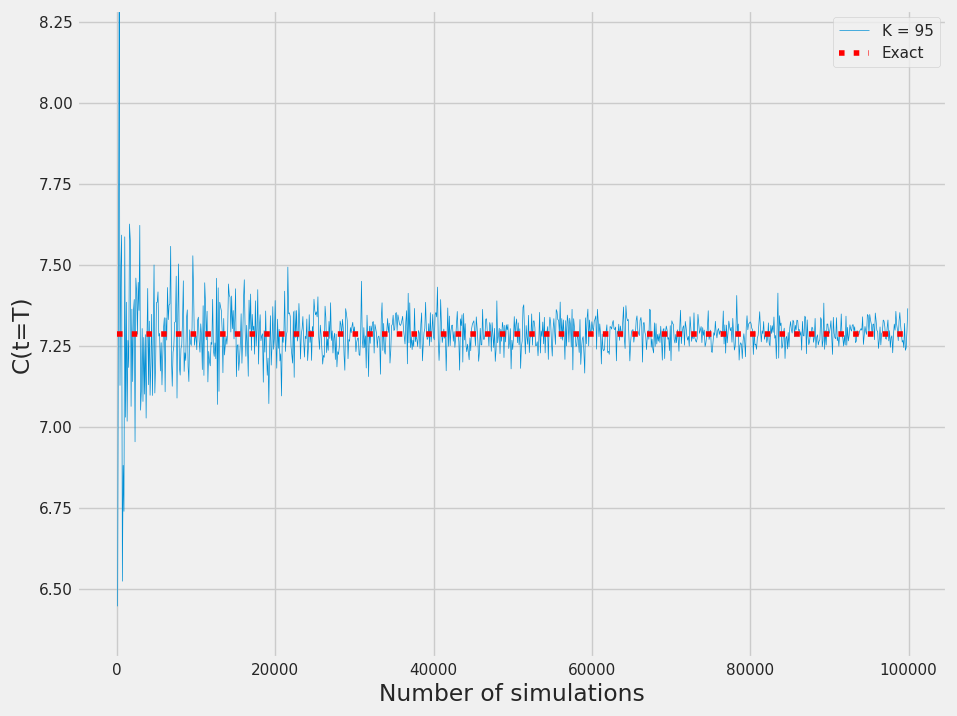

In [10]:
k = np.arange(100, 100_000, 100)
vfunc1 = np.vectorize(Crude_Monte_Carlo)
R1 = vfunc1(k,r, sigma, deltaT, K, s0 )
plt.figure(figsize = (10,8))
sns.lineplot(y = R1, x = k, label = 'K = 95',linewidth=0.5)
plt.ylim(BS(s0,K,deltaT)-1,BS(s0,K,deltaT)+1)
plt.hlines(BS(s0,K,deltaT),xmin=0,xmax= k[-1],linestyle='dotted',colors='red',label = 'Exact')
plt.xlabel('Number of simulations')
plt.ylabel('C(t=T)')

plt.legend()
plt.show()

**Introduction to variance reduction methods**


It can be shown that the ratio $\frac{\sigma}{\sqrt(N)}$ governs the accuracy of
a Monte-Carlo method with N simulations. An obvious consequence of this fact is that one
always has interest to rewrite the quantity to compute as the expectation of a random variable
which has a smaller variance : this is the basic idea of variance reduction techniques.



**Using call-put arbitrage formula for variance reduction**

Let $S_t$ be the price at time $t$ of an underlying asset. Denote by $C(S,t)$ the price of the European call option:
$$C(S,t) = \widetilde{\mathbb{E}}(e^{-r\Delta T}(S_T - K))$$
Denote by $P(S,t)$ the price of the European put option:
$$P(S,t) = \widetilde{\mathbb{E}}(e^{-r\Delta T}(K - S_T))$$
where $\widetilde{\mathbb{E}}$ denotes a risk-neutral expectation and $r$ is a risk-neutral interest rate.
Let's now use well know call-put parity. It is an equation that relates an call and put options with the same underlying asset.
$$C(S,t) - P(S,t) = \widetilde{\mathbb{E}}(e^{-r\Delta T}(S_T - K)) = S_0- e^{-r\Delta T} K$$
Thus we can use price for put option to compute price of a call option. Moreover, the variance of the put option is smaller than the
variance of the call since the payoff of the put is bounded whereas the payoff of the call is not.
We will use the following formalu to compute price of an european call option:
$$C(S,t) = \widetilde{\mathbb{E}}(e^{-r\Delta T}(K - S_T)) + S_0- e^{-r\Delta T}$$



In [11]:
def CallfromPut_Monte_Carlo(k, r, sigma, deltaT, K, s0):# the price of the product at the maturnity simulation
    z = np.random.normal(0, 1, [1, k])
    S= K - s0*np.exp((r-(sigma**2)/2)*deltaT+sigma*math.sqrt(deltaT)*z)
    R = math.exp(-r*deltaT)*np.sum(S[S>0])/k + s0 - math.exp(-r*deltaT)*K
    return R

In [12]:
CallfromPut_Monte_Carlo(1000000, r, sigma, deltaT, K, s0)

7.282041290905013

Let's compute a standard error as in the previous section.

In [13]:
def STERR_CallfromPut_Monte_Carlo(k, r, sigma, deltaT, K, s0):# the price of the product at the maturnity simulation
    z = np.random.normal(0, 1, [1, k])
    S= K - s0*np.exp((r-(sigma**2)/2)*deltaT+sigma*math.sqrt(deltaT)*z)
    R = math.exp(-r*deltaT)*S[S>0] + s0 - math.exp(-r*deltaT)*K
    R = np.std(R)/np.sqrt(k)
    return R

For number of simulations  t  standard error is the following:

In [14]:
t = 1000000
STERR_CallfromPut_Monte_Carlo(t, r, sigma, deltaT, K, s0)

0.007010700444372475

Indeed, the SE is smaller. Also, the lower variability of the price can be seen on the graph below. Therefore, we can achieve better result for lower number of simulation when we use call-put paruty method.

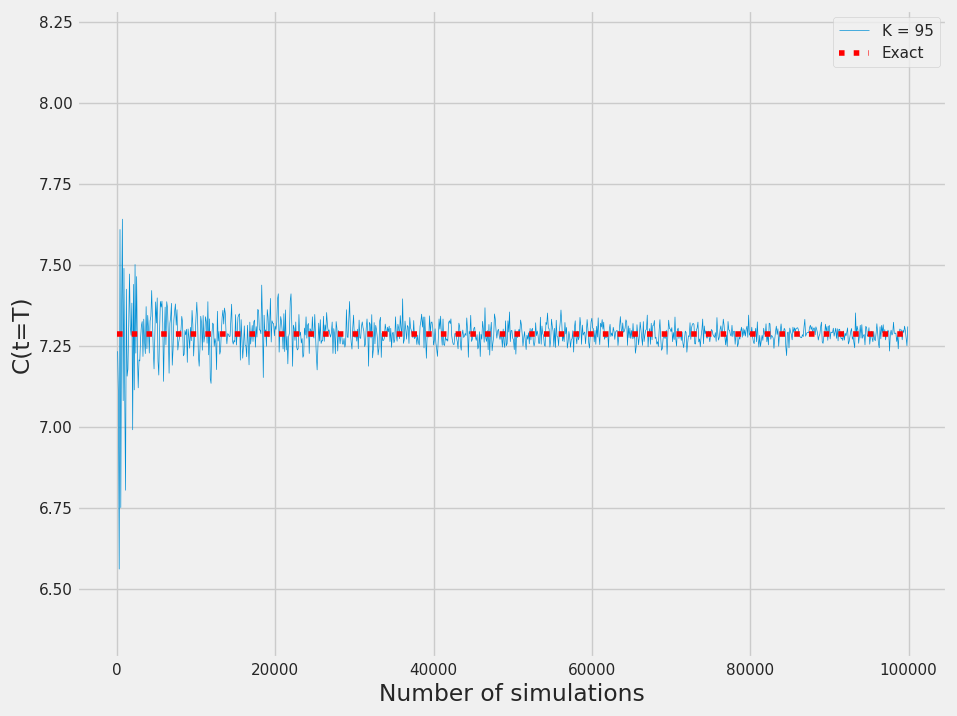

In [15]:
k = np.arange(100, 100_000, 100)
vfunc1 = np.vectorize(CallfromPut_Monte_Carlo)
R1 = vfunc1(k,r, sigma, deltaT, K, s0)
plt.figure(figsize = (10,8))
sns.lineplot(y = R1, x = k, label = 'K = 95',linewidth=0.5)
plt.ylim(BS(s0,K,deltaT)-1,BS(s0,K,deltaT)+1)
plt.hlines(BS(s0,K,deltaT),xmin=0,xmax= k[-1],linestyle='dotted',colors='red',label = 'Exact')
plt.xlabel('Number of simulations')
plt.ylabel('C(t=T)')

plt.legend()
plt.show()

**Antithetic Variates Method**

In [16]:
def Ant_Monte_Carlo(k, r, sigma, deltaT, K, s0):# the price of the product at the maturnity simulation
    z = np.random.normal(0, 1, [1, k])
    S1= s0*np.exp((r-(sigma**2)/2)*deltaT + sigma*(math.sqrt(deltaT)*z)) - K
    S1[S1<0] = 0
    S2= s0*np.exp((r-(sigma**2)/2)*deltaT - sigma*(math.sqrt(deltaT)*z)) - K
    S2[S2<0] = 0
    R1 = math.exp(-r*deltaT)*(S1)
    R2 = math.exp(-r*deltaT)*(S2)
    R = (R1 + R2)/2
    return np.mean(R)

In [17]:
Ant_Monte_Carlo(1000000, r, sigma, deltaT, K, s0)

7.290355285510262

In [18]:
def STERR_Ant_Monte_Carlo(k, r, sigma, deltaT, K, s0):# the price of the product at the maturnity simulation
    z = np.random.normal(0, 1, [1, k])
    S1= s0*np.exp((r-(sigma**2)/2)*deltaT + sigma*(math.sqrt(deltaT)*z)) - K
    S1[S1<0] = 0
    S2= s0*np.exp((r-(sigma**2)/2)*deltaT - sigma*(math.sqrt(deltaT)*z)) - K
    S2[S2<0] = 0
    R1 = math.exp(-r*deltaT)*S1
    R2 = math.exp(-r*deltaT)*S2
    R = (R1 + R2)/2
    R = np.std(R)/np.sqrt(k)
    return R

In [19]:
t = 1000000
STERR_Ant_Monte_Carlo(t, r, sigma, deltaT, K, s0)

0.004993147037886448

Antithetic Variates Method gives result wuth the lowest standard error among models that we have used.

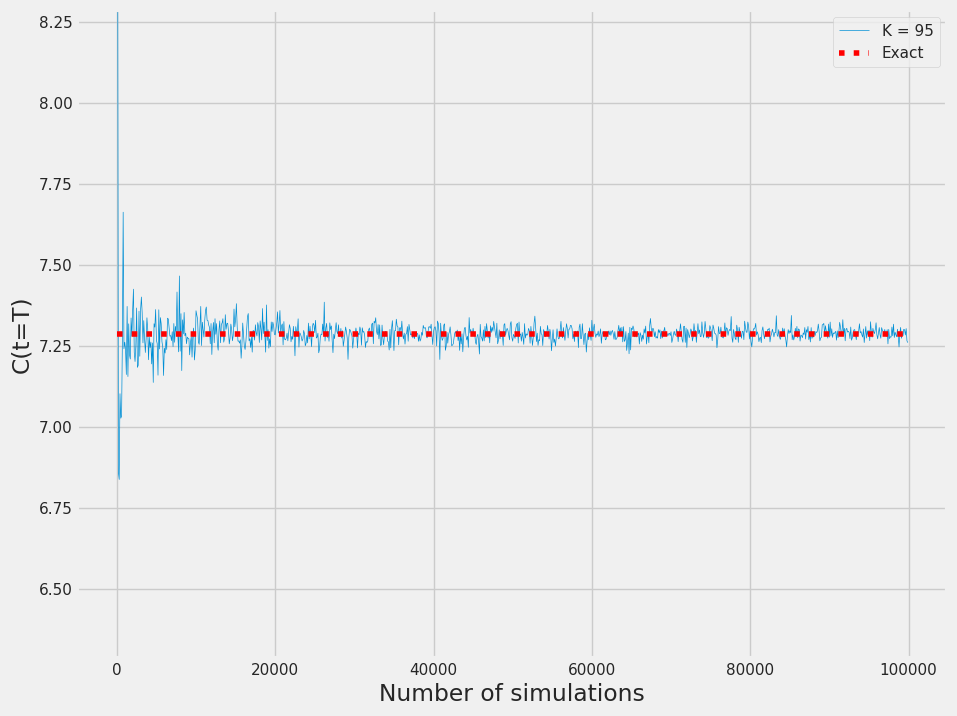

In [20]:
k = np.arange(100, 100_000, 100)
vfunc1 = np.vectorize(Ant_Monte_Carlo)
R1 = vfunc1(k,r, sigma, deltaT, K, s0)
plt.figure(figsize = (10,8))
sns.lineplot(y = R1, x = k, label = 'K = 95',linewidth=0.5)
plt.ylim(BS(s0,K,deltaT)-1,BS(s0,K,deltaT)+1)
plt.hlines(BS(s0,K,deltaT),xmin=0,xmax= k[-1],linestyle='dotted',colors='red',label = 'Exact')
plt.xlabel('Number of simulations')
plt.ylabel('C(t=T)')

plt.legend()
plt.show()

**Results**







In [42]:
r=0.02 # annualized risk-free interest rate
sigma=0.2 #  is the standard deviation/ volatility of the stock's returns
deltaT=0.5 # time to maturity
s0=102# stock's price
K=100# strike price
t = 100_000_000

In [43]:
BS_price = BS(s0,K,deltaT)
Crude_Monte_Carlo_price = Crude_Monte_Carlo(t, r, sigma, deltaT, K,s0)
Standard_error_crude_MC = STERR_Crude_MC(t, r, sigma, deltaT, K, s0)
CallfromPut_Monte_Carlo_price = CallfromPut_Monte_Carlo(t, r, sigma, deltaT, K, s0)
Standard_error_CallfromPut_MC = STERR_CallfromPut_Monte_Carlo(t, r, sigma, deltaT, K, s0)
Ant_Monte_Carlo_price = Ant_Monte_Carlo(t, r, sigma, deltaT, K, s0)
Standard_error_Ant_MC = STERR_Ant_Monte_Carlo(t, r, sigma, deltaT, K, s0)





In [44]:
D = {"Price":[BS_price,Crude_Monte_Carlo_price,CallfromPut_Monte_Carlo_price,Ant_Monte_Carlo_price],
     " Standard Error":[0,Standard_error_crude_MC,Standard_error_CallfromPut_MC,Standard_error_Ant_MC]}
df = pd.DataFrame({"Method": ["Exact Solution","Crude_Monte_Carlo", "CallfromPut_Monte_Carlo","Antithetic Variates_Monte_Carlo"]})
df = pd.concat([df, pd.DataFrame(D)],
               axis=1)
df

Method     Price   Standard Error
0                   Exact Solution  7.288151         0.000000
1                Crude_Monte_Carlo  7.288761         0.001041
2          CallfromPut_Monte_Carlo  7.288173         0.000701
3  Antithetic Variates_Monte_Carlo  7.286901         0.000500

As it can be seen in the table above. Variance reduction methods lower standard error of the computed prices. Expecially, Antithetic Variates methods, which gives the lowest standard error.